## Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
!"C:\Program Files\NVIDIA Corporation\NVSMI\nvidia-smi.exe"

Mon Apr 01 02:26:42 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 399.24                 Driver Version: 399.24                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 970    WDDM  | 00000000:01:00.0  On |                  N/A |
| 35%   31C    P8    18W / 250W |    277MiB /  4096MiB |      7%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
import keras
from keras.regularizers import l1, l2, l1_l2
import tensorflow as tf
from numba import cuda
cuda.select_device(0)
cuda.close()

import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
#  1 : 在 Dense 層中增加 Regularizers
#  2 : 增加 Dropout 層並設定 dropout ratio 
#  3 : 增加 Batch-normalization 層

In [13]:
## 超參數設定

LEARNING_RATE = 1e-3
OPTIMIZER = ['Adam','RMSprop']
EPOCHS = 50
BATCH_SIZE = 512

In [19]:
def build_mlp(input_shape, output_units=y_train.shape[-1], 
              l1_alpha=0.01, l2_alpha=0.01, drp_ratio=0.1, 
              n_layers=4, num_neurons=[512, 256, 128, 64]):
    
    ### Input Layer
    input_layer = keras.layers.Input(input_shape)
    x = keras.layers.BatchNormalization()(input_layer)
    
    #### Hidden Layer
    for i, n_units in enumerate(num_neurons[:n_layers]):
        
        if i == 0:
            x = keras.layers.Dense(units=n_units,activation='relu',
                                   kernel_regularizer=l1_l2(l1=l1_alpha, l2=l2_alpha),
                                   name='hidden_layers'+str(i+1))(x)    
        else:
            x = keras.layers.Dense(units=n_units,activation='relu',
                                   kernel_regularizer=l1_l2(l1=l1_alpha, l2=l2_alpha),
                                   name='hidden_layers'+str(i+1))(x)    
        
        x = keras.layers.Dropout(drp_ratio)(x)
        x = keras.layers.BatchNormalization()(x)

    ### Output Layer
    output_layer = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)

    
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])   
    return model

In [20]:
def model_fitting( learning_rate=LEARNING_RATE, optimizer=OPTIMIZER, 
                  epochs=EPOCHS, batch_size=BATCH_SIZE, input_shape=x_train.shape[1:] ):

    keras.backend.clear_session()
    ########################################
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)
    ########################################
    
    model = build_mlp( input_shape=input_shape )
    model.summary()

    selector = {'SGD': keras.optimizers.SGD(lr=learning_rate, momentum=0.95, nesterov=True),
                'RMSprop': keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None),
                'AdaGrad': keras.optimizers.Adagrad(lr=learning_rate, epsilon=None), 
                'Adam': keras.optimizers.Adam(lr=learning_rate, epsilon=None, amsgrad=True)}

    optimizer = selector.get(optimizer)

    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    history = model.fit(x_train, y_train, epochs=epochs, 
                        batch_size=batch_size,validation_data=(x_test, y_test), 
                        shuffle=False, verbose=1)
    ##################
    sess.close()
    ##################
    
    return history

In [22]:
results = {}

for opt in OPTIMIZER : 
    
    outcome = model_fitting( optimizer = opt )
    
    name_tag = f'Optimizer = {opt}'
    results[name_tag] = {'train-loss': outcome.history['loss'],
                         'valid-loss': outcome.history['val_loss'],
                         'train-acc': outcome.history['acc'],
                         'valid-acc': outcome.history['val_acc']}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layers1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layers2 (Dense)       (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

50000/50000 [==============================] - 4s 73us/step - loss: 4.1463 - acc: 0.3329 - val_loss: 4.0924 - val_acc: 0.3395
Epoch 44/50
50000/50000 [==============================] - 4s 73us/step - loss: 4.1352 - acc: 0.3338 - val_loss: 4.0371 - val_acc: 0.3601
Epoch 45/50
50000/50000 [==============================] - 4s 72us/step - loss: 4.1332 - acc: 0.3326 - val_loss: 4.2366 - val_acc: 0.3059
Epoch 46/50
50000/50000 [==============================] - 4s 74us/step - loss: 4.1391 - acc: 0.3371 - val_loss: 4.0920 - val_acc: 0.3547
Epoch 47/50
50000/50000 [==============================] - 4s 73us/step - loss: 4.1207 - acc: 0.3381 - val_loss: 4.0440 - val_acc: 0.3597
Epoch 48/50
50000/50000 [==============================] - 4s 72us/step - loss: 4.1045 - acc: 0.3335 - val_loss: 4.0405 - val_acc: 0.3616
Epoch 49/50
50000/50000 [==============================] - 4s 72us/step - loss: 4.0882 - acc: 0.3325 - val_loss: 3.9994 - val_acc: 0.3575
Epoch 50/50
50000/50000 [=====================

Epoch 35/50
50000/50000 [==============================] - 3s 69us/step - loss: 10.7409 - acc: 0.2925 - val_loss: 10.7465 - val_acc: 0.3161
Epoch 36/50
50000/50000 [==============================] - 3s 69us/step - loss: 10.7425 - acc: 0.2935 - val_loss: 10.7244 - val_acc: 0.3143
Epoch 37/50
50000/50000 [==============================] - 3s 69us/step - loss: 10.7349 - acc: 0.2953 - val_loss: 10.7084 - val_acc: 0.3380
Epoch 38/50
50000/50000 [==============================] - 4s 70us/step - loss: 10.7321 - acc: 0.2954 - val_loss: 10.7127 - val_acc: 0.3276
Epoch 39/50
50000/50000 [==============================] - 3s 69us/step - loss: 10.7276 - acc: 0.2960 - val_loss: 10.6871 - val_acc: 0.3116
Epoch 40/50
50000/50000 [==============================] - 3s 70us/step - loss: 10.7228 - acc: 0.3015 - val_loss: 10.7187 - val_acc: 0.3175
Epoch 41/50
50000/50000 [==============================] - 4s 70us/step - loss: 10.7256 - acc: 0.2996 - val_loss: 10.7132 - val_acc: 0.3196
Epoch 42/50
50000/50

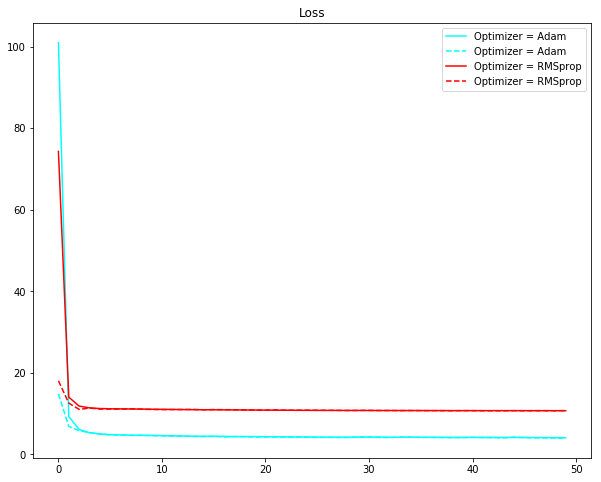

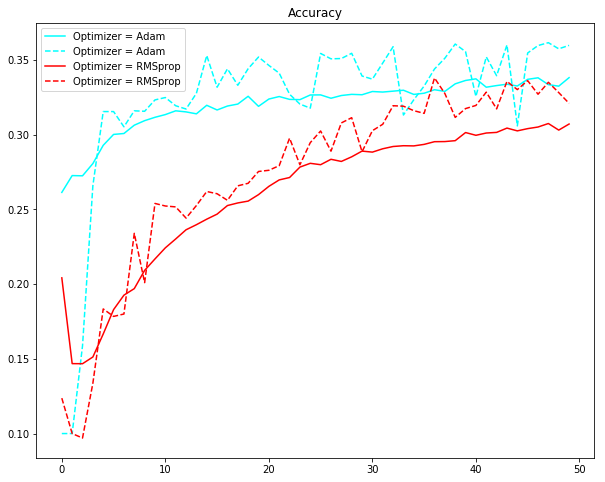

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ['aqua','red','gold']

plt.figure(figsize=(10, 8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()